In [1]:
import torch as tc
from torch import optim, nn 
from torch.utils.data import TensorDataset, DataLoader, random_split 

from datasets import load_dataset
from torchvision import datasets as DataSet
from torchvision import transforms as T
from torchvision import models

import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from torchmetrics import Accuracy

from tqdm import tqdm 

/home/ahmadrezabaqerzadeh/.local/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
xtrain = tc.load('/home/ahmadrezabaqerzadeh/datasets/human-action-detection/train/xtrain.csv')
ytrain =tc.load('/home/ahmadrezabaqerzadeh/datasets/human-action-detection/train/ytrain.csv')

In [3]:
xtrain.dtype, xtrain.shape, ytrain.dtype, ytrain.shape

(torch.float32, torch.Size([12600, 3, 100, 100]), dtype('int64'), (12600,))

In [4]:
xtest = tc.load('/home/ahmadrezabaqerzadeh/datasets/human-action-detection/test/xtest.csv')
ytest = tc.load('/home/ahmadrezabaqerzadeh/datasets/human-action-detection/test/ytest.csv')

In [5]:
xtest.dtype, xtest.shape, ytest.dtype, ytest.shape

(torch.float32, torch.Size([5400, 3, 100, 100]), dtype('int64'), (5400,))

In [6]:
ytrain = tc.LongTensor(ytrain)
ytest = tc.LongTensor(ytest)

In [7]:
xtrain = np.array(xtrain)
ytrain = np.array(ytrain)

In [8]:
xtrain, xvalid, ytrain, yvalid = train_test_split(xtrain, ytrain, train_size = 0.9, random_state = 42)

In [9]:
xtrain = tc.FloatTensor(xtrain)
ytrain = tc.LongTensor(ytrain)

xvalid = tc.FloatTensor(xvalid)
yvalid = tc.LongTensor(yvalid)

In [10]:
mean = xtrain.mean(dim = [0, 2, 3])
std = xtrain.std(dim = [0, 2, 3])

In [11]:
xtrain = ((xtrain.permute(0, 2, 3, 1) - mean)/std).permute(0, 3, 1, 2)
xvalid = ((xvalid.permute(0, 2, 3, 1) - mean)/std).permute(0, 3, 1, 2)
xtest =  ((xtest.permute(0, 2, 3, 1) - mean)/std).permute(0, 3, 1, 2)

In [12]:
train_dataset = TensorDataset(xtrain, ytrain)
valid_dataset = TensorDataset(xvalid, yvalid)

In [13]:
train_loader = DataLoader(train_dataset, batch_size = 256, shuffle = True)
valid_loader = DataLoader(valid_dataset, batch_size = 128, shuffle = False)

In [14]:
device = 'cuda' if tc.cuda.is_available() else 'cpu'
device

'cuda'

In [15]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [16]:
def train_one_epoch(model, train_loader, loss_func, optimizer, epoch):
    model.train()

    train_loss=AverageMeter()
    train_acc=Accuracy(task='multiclass', num_classes=15).to(device)

    with tqdm(train_loader, unit='batch') as tepoch:
        for x, y in tepoch:
            if epoch is not None:
                tepoch.set_description(f'Epoch={epoch}')

            x=x.to(device)
            y=y.to(device)

            yp=model(x)
        
            loss=loss_func(yp.squeeze(),  y)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            train_loss.update(loss.item())
            train_acc(yp.squeeze(), y.int())

            tepoch.set_postfix(loss=train_loss.avg, Accuracy=train_acc.compute().item() * 100)

    return model, train_loss.avg, train_acc.compute().item()

In [17]:
def validation(model, valid_loaedr, loss_func):
    model.eval()

    valid_loss=AverageMeter()
    valid_acc=Accuracy(task='multiclass', num_classes=15).to(device)

    for x, y in valid_loaedr:

        x=x.to(device)
        y=y.to(device)

        yp=model(x)
        loss=loss_func(yp.squeeze(), y)

        valid_loss.update(loss.item())
        valid_acc(yp.squeeze(), y)

    print(f'valid loss={valid_loss.avg:.4}, accuracy={valid_acc.compute().item() * 100 :.4}')
    print()

    return valid_loss.avg, valid_acc.compute().item()

In [18]:
class CNNModel(nn.Module):
    
    def __init__(self, num_filters, kernel_size, num_classes):
        super().__init__()
        
        self.conv1 = nn.LazyConv2d(num_filters, kernel_size, stride = 1, padding = 1, bias = True)
        self.bn1 = nn.LazyBatchNorm2d()
        
        self.mpool1 = nn.MaxPool2d(2, 2)
        
        self.conv2 = nn.LazyConv2d(num_filters, kernel_size, stride = 1, padding = 1)
        self.bn2 = nn.LazyBatchNorm2d()
        
        self.mpool2 = nn.MaxPool2d(2, 2)
        
        self.conv3 = nn.LazyConv2d(num_filters, kernel_size, stride = 1, padding = 1)
        self.bn3 = nn.LazyBatchNorm2d()
        
        self.mpool3 = nn.MaxPool2d(2, 2)
        
        self.conv4 = nn.LazyConv2d(num_filters, kernel_size, stride = 1, padding = 1)
        self.bn4 = nn.LazyBatchNorm2d()
        
        self.mpool4 = nn.MaxPool2d(2, 2)
        
        self.conv5 = nn.LazyConv2d(num_filters, kernel_size, stride = 1, padding = 1, bias = True)
        self.bn5 = nn.LazyBatchNorm2d()
        
        self.mpool5 = nn.MaxPool2d(2, 2)
        
        self.conv6 = nn.LazyConv2d(num_filters, kernel_size, stride = 1, padding = 1, bias = True)
        self.bn6 = nn.LazyBatchNorm2d()
        
        self.mpool6 = nn.MaxPool2d(2, 2)
        
        self.conv7 = nn.LazyConv2d(num_filters, kernel_size, stride = 1, padding = 1)
        self.bn7 = nn.LazyBatchNorm2d()
        
        self.apool = nn.AdaptiveAvgPool2d(output_size = (1, 1))
        
        self.fc = nn.LazyLinear(num_classes)
        
        self.seq = nn.Sequential(nn.LazyLinear(128), nn.ReLU(), nn.LazyLinear(16), nn.ReLU(), nn.LazyLinear(num_classes))
        
    def forward(self, x):
        
        y = self.conv1(x)
        y = self.bn1(y)
        y = y.relu()
        y = self.mpool1(y)
        
        y = self.conv2(y)
        y = self.bn2(y)
        y = y.relu()
        y = self.mpool2(y)
        
        y = self.conv3(y)
        y = self.bn3(y)
        y = y.relu()
        y = self.mpool3(y)
        
        y = self.conv4(y)
        y = self.bn4(y)
        y = y.relu()
        y = self.mpool4(y)
        
        y = self.conv5(y)
        y = self.bn5(y)
        y = y.relu()
        y = self.mpool5(y)
        
        y = self.conv6(y)
        y = self.bn6(y)
        y = y.relu()
        y = self.mpool6(y)
        
        y = self.conv7(y)
        y = self.bn7(y)
        y = y.relu()
        
        #y = self.apool(y)
        
        y = y.flatten(1)
        
        y = self.fc(y)
        
        return y

In [19]:
model = models.DenseNet(num_classes=15).to(device)

In [20]:
num_classes = 15

In [21]:
model.fc = nn.LazyLinear(num_classes).to(device)

/home/ahmadrezabaqerzadeh/.local/lib/python3.10/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [22]:
model = CNNModel(16, 3, 15).to(device)

In [23]:
optimizer = optim.Adam(model.parameters(), lr = 0.0001, betas = [0.9, 0.99])
loss_func = nn.CrossEntropyLoss()

In [24]:
loss_train_hist, acc_train_hist = [], []
loss_valid_hist, acc_valid_hist = [], []

best_loss = tc.inf 
best_model = [0]

In [25]:
N = 100
for i in range(N):

  model, train_loss, train_acc = train_one_epoch(model, train_loader, loss_func, optimizer, i)
  valid_loss, valid_acc = validation(model,valid_loader,loss_func)

  acc_train_hist.append(train_acc)
  loss_train_hist.append(train_loss)

  acc_valid_hist.append(valid_acc)
  loss_valid_hist.append(valid_loss)

  if valid_loss<best_loss:
    best_loss = valid_loss
    best_model[0] = model
    print('model saved!')

Epoch=0: 100%|██████████| 45/45 [00:04<00:00, 10.31batch/s, Accuracy=7.09, loss=2.75]


valid loss=2.702, accuracy=7.778

model saved!


Epoch=1: 100%|██████████| 45/45 [00:03<00:00, 13.51batch/s, Accuracy=9.96, loss=2.68]


valid loss=2.672, accuracy=9.048

model saved!


Epoch=2: 100%|██████████| 45/45 [00:03<00:00, 13.41batch/s, Accuracy=11.4, loss=2.64]


valid loss=2.643, accuracy=10.56

model saved!


Epoch=3: 100%|██████████| 45/45 [00:03<00:00, 13.46batch/s, Accuracy=12.9, loss=2.61]


valid loss=2.615, accuracy=11.9

model saved!


Epoch=4: 100%|██████████| 45/45 [00:03<00:00, 14.20batch/s, Accuracy=14.2, loss=2.58]


valid loss=2.598, accuracy=12.94

model saved!


Epoch=5: 100%|██████████| 45/45 [00:03<00:00, 14.09batch/s, Accuracy=15.8, loss=2.56]


valid loss=2.579, accuracy=14.21

model saved!


Epoch=6: 100%|██████████| 45/45 [00:03<00:00, 14.21batch/s, Accuracy=17, loss=2.53]  


valid loss=2.56, accuracy=15.56

model saved!


Epoch=7: 100%|██████████| 45/45 [00:03<00:00, 14.28batch/s, Accuracy=18.1, loss=2.51]


valid loss=2.542, accuracy=16.51

model saved!


Epoch=8: 100%|██████████| 45/45 [00:03<00:00, 14.08batch/s, Accuracy=19.1, loss=2.5] 


valid loss=2.529, accuracy=16.75

model saved!


Epoch=9: 100%|██████████| 45/45 [00:03<00:00, 14.28batch/s, Accuracy=19.9, loss=2.48]


valid loss=2.519, accuracy=17.78

model saved!


Epoch=10: 100%|██████████| 45/45 [00:03<00:00, 14.28batch/s, Accuracy=20.8, loss=2.46]


valid loss=2.511, accuracy=18.33

model saved!


Epoch=11: 100%|██████████| 45/45 [00:03<00:00, 14.15batch/s, Accuracy=21.4, loss=2.45]


valid loss=2.497, accuracy=18.97

model saved!


Epoch=12: 100%|██████████| 45/45 [00:03<00:00, 14.26batch/s, Accuracy=22.3, loss=2.43]


valid loss=2.488, accuracy=18.81

model saved!


Epoch=13: 100%|██████████| 45/45 [00:03<00:00, 14.26batch/s, Accuracy=23, loss=2.42]  


valid loss=2.475, accuracy=20.24

model saved!


Epoch=14: 100%|██████████| 45/45 [00:03<00:00, 14.25batch/s, Accuracy=23.7, loss=2.4] 


valid loss=2.465, accuracy=19.92

model saved!


Epoch=15: 100%|██████████| 45/45 [00:03<00:00, 14.13batch/s, Accuracy=24.3, loss=2.39]


valid loss=2.454, accuracy=20.56

model saved!


Epoch=16: 100%|██████████| 45/45 [00:03<00:00, 14.22batch/s, Accuracy=24.9, loss=2.38]


valid loss=2.447, accuracy=20.79

model saved!


Epoch=17: 100%|██████████| 45/45 [00:03<00:00, 14.26batch/s, Accuracy=25.4, loss=2.36]


valid loss=2.435, accuracy=21.35

model saved!


Epoch=18: 100%|██████████| 45/45 [00:03<00:00, 14.19batch/s, Accuracy=25.9, loss=2.35]


valid loss=2.428, accuracy=20.87

model saved!


Epoch=19: 100%|██████████| 45/45 [00:03<00:00, 14.26batch/s, Accuracy=26.2, loss=2.34]


valid loss=2.424, accuracy=21.35

model saved!


Epoch=20: 100%|██████████| 45/45 [00:03<00:00, 14.26batch/s, Accuracy=26.8, loss=2.32]


valid loss=2.415, accuracy=20.4

model saved!


Epoch=21: 100%|██████████| 45/45 [00:03<00:00, 14.21batch/s, Accuracy=27.2, loss=2.31]


valid loss=2.407, accuracy=22.3

model saved!


Epoch=22: 100%|██████████| 45/45 [00:03<00:00, 14.21batch/s, Accuracy=28.1, loss=2.3] 


valid loss=2.4, accuracy=22.22

model saved!


Epoch=23: 100%|██████████| 45/45 [00:03<00:00, 14.13batch/s, Accuracy=27.7, loss=2.29]


valid loss=2.395, accuracy=21.59

model saved!


Epoch=24: 100%|██████████| 45/45 [00:03<00:00, 14.00batch/s, Accuracy=28.7, loss=2.27]


valid loss=2.388, accuracy=22.54

model saved!


Epoch=25: 100%|██████████| 45/45 [00:03<00:00, 13.91batch/s, Accuracy=29.1, loss=2.26]


valid loss=2.378, accuracy=21.9

model saved!


Epoch=26: 100%|██████████| 45/45 [00:03<00:00, 13.66batch/s, Accuracy=29.4, loss=2.25]


valid loss=2.376, accuracy=22.78

model saved!


Epoch=27: 100%|██████████| 45/45 [00:03<00:00, 12.99batch/s, Accuracy=30, loss=2.23]  


valid loss=2.366, accuracy=23.02

model saved!


Epoch=28: 100%|██████████| 45/45 [00:03<00:00, 13.46batch/s, Accuracy=30.2, loss=2.22]


valid loss=2.363, accuracy=22.86

model saved!


Epoch=29: 100%|██████████| 45/45 [00:03<00:00, 13.76batch/s, Accuracy=30.5, loss=2.21]


valid loss=2.353, accuracy=23.02

model saved!


Epoch=30: 100%|██████████| 45/45 [00:03<00:00, 13.55batch/s, Accuracy=30.6, loss=2.2] 


valid loss=2.346, accuracy=23.49

model saved!


Epoch=31: 100%|██████████| 45/45 [00:03<00:00, 13.82batch/s, Accuracy=31.2, loss=2.18]


valid loss=2.342, accuracy=22.86

model saved!


Epoch=32: 100%|██████████| 45/45 [00:03<00:00, 14.04batch/s, Accuracy=31.7, loss=2.18]


valid loss=2.34, accuracy=23.25

model saved!


Epoch=33: 100%|██████████| 45/45 [00:03<00:00, 14.14batch/s, Accuracy=32.3, loss=2.16]


valid loss=2.336, accuracy=23.17

model saved!


Epoch=34: 100%|██████████| 45/45 [00:03<00:00, 14.11batch/s, Accuracy=32.7, loss=2.15]


valid loss=2.333, accuracy=23.1

model saved!


Epoch=35: 100%|██████████| 45/45 [00:03<00:00, 13.98batch/s, Accuracy=32.8, loss=2.14]


valid loss=2.33, accuracy=23.73

model saved!


Epoch=36: 100%|██████████| 45/45 [00:03<00:00, 13.63batch/s, Accuracy=33.1, loss=2.13]


valid loss=2.323, accuracy=23.73

model saved!


Epoch=37: 100%|██████████| 45/45 [00:03<00:00, 14.00batch/s, Accuracy=33.4, loss=2.12]


valid loss=2.319, accuracy=23.89

model saved!


Epoch=38: 100%|██████████| 45/45 [00:03<00:00, 13.95batch/s, Accuracy=33.4, loss=2.11]


valid loss=2.314, accuracy=24.13

model saved!


Epoch=39: 100%|██████████| 45/45 [00:03<00:00, 14.09batch/s, Accuracy=34.2, loss=2.1] 


valid loss=2.309, accuracy=24.05

model saved!


Epoch=40: 100%|██████████| 45/45 [00:03<00:00, 14.21batch/s, Accuracy=34.5, loss=2.09]


valid loss=2.306, accuracy=24.21

model saved!


Epoch=41: 100%|██████████| 45/45 [00:03<00:00, 14.02batch/s, Accuracy=34.8, loss=2.08]


valid loss=2.308, accuracy=23.41



Epoch=42: 100%|██████████| 45/45 [00:03<00:00, 14.03batch/s, Accuracy=35.1, loss=2.06]


valid loss=2.302, accuracy=24.44

model saved!


Epoch=43: 100%|██████████| 45/45 [00:03<00:00, 13.68batch/s, Accuracy=35.5, loss=2.06]


valid loss=2.3, accuracy=24.84

model saved!


Epoch=44: 100%|██████████| 45/45 [00:03<00:00, 13.51batch/s, Accuracy=35.4, loss=2.04]


valid loss=2.302, accuracy=24.05



Epoch=45: 100%|██████████| 45/45 [00:03<00:00, 13.98batch/s, Accuracy=35.8, loss=2.04]


valid loss=2.304, accuracy=23.97



Epoch=46: 100%|██████████| 45/45 [00:03<00:00, 13.82batch/s, Accuracy=36.2, loss=2.03]


valid loss=2.302, accuracy=24.37



Epoch=47: 100%|██████████| 45/45 [00:03<00:00, 14.16batch/s, Accuracy=36.2, loss=2.02]


valid loss=2.296, accuracy=24.52

model saved!


Epoch=48: 100%|██████████| 45/45 [00:03<00:00, 13.97batch/s, Accuracy=36.7, loss=2.01]


valid loss=2.295, accuracy=23.49

model saved!


Epoch=49: 100%|██████████| 45/45 [00:03<00:00, 13.66batch/s, Accuracy=36.9, loss=2]   


valid loss=2.288, accuracy=24.68

model saved!


Epoch=50: 100%|██████████| 45/45 [00:03<00:00, 13.64batch/s, Accuracy=37.4, loss=1.99]


valid loss=2.291, accuracy=24.29



Epoch=51: 100%|██████████| 45/45 [00:03<00:00, 13.72batch/s, Accuracy=37.4, loss=1.98]


valid loss=2.288, accuracy=24.6

model saved!


Epoch=52: 100%|██████████| 45/45 [00:03<00:00, 13.30batch/s, Accuracy=37.7, loss=1.97]


valid loss=2.289, accuracy=24.37



Epoch=53: 100%|██████████| 45/45 [00:03<00:00, 13.23batch/s, Accuracy=38.5, loss=1.96]


valid loss=2.288, accuracy=23.57



Epoch=54: 100%|██████████| 45/45 [00:03<00:00, 13.13batch/s, Accuracy=38.2, loss=1.96]


valid loss=2.282, accuracy=23.81

model saved!


Epoch=55: 100%|██████████| 45/45 [00:03<00:00, 13.40batch/s, Accuracy=38.4, loss=1.95]


valid loss=2.293, accuracy=24.29



Epoch=56: 100%|██████████| 45/45 [00:03<00:00, 13.42batch/s, Accuracy=38.9, loss=1.94]


valid loss=2.296, accuracy=23.97



Epoch=57: 100%|██████████| 45/45 [00:03<00:00, 12.87batch/s, Accuracy=38.9, loss=1.93]


valid loss=2.282, accuracy=23.97



Epoch=58: 100%|██████████| 45/45 [00:03<00:00, 12.99batch/s, Accuracy=39.2, loss=1.92]


valid loss=2.284, accuracy=24.6



Epoch=59: 100%|██████████| 45/45 [00:03<00:00, 13.20batch/s, Accuracy=39.5, loss=1.91]


valid loss=2.287, accuracy=24.05



Epoch=60: 100%|██████████| 45/45 [00:03<00:00, 13.45batch/s, Accuracy=39.6, loss=1.91]


valid loss=2.286, accuracy=24.76



Epoch=61: 100%|██████████| 45/45 [00:03<00:00, 13.22batch/s, Accuracy=40, loss=1.9]   


valid loss=2.287, accuracy=23.97



Epoch=62: 100%|██████████| 45/45 [00:03<00:00, 13.19batch/s, Accuracy=40.1, loss=1.89]


valid loss=2.29, accuracy=24.05



Epoch=63: 100%|██████████| 45/45 [00:03<00:00, 13.33batch/s, Accuracy=40.4, loss=1.88]


valid loss=2.289, accuracy=24.52



Epoch=64: 100%|██████████| 45/45 [00:03<00:00, 13.44batch/s, Accuracy=41.1, loss=1.87]


valid loss=2.289, accuracy=25.32



Epoch=65: 100%|██████████| 45/45 [00:03<00:00, 13.33batch/s, Accuracy=40.8, loss=1.87]


valid loss=2.287, accuracy=24.44



Epoch=66: 100%|██████████| 45/45 [00:03<00:00, 13.21batch/s, Accuracy=41.4, loss=1.85]


valid loss=2.293, accuracy=24.05



Epoch=67: 100%|██████████| 45/45 [00:03<00:00, 12.79batch/s, Accuracy=41.4, loss=1.85]


valid loss=2.303, accuracy=24.21



Epoch=68: 100%|██████████| 45/45 [00:03<00:00, 13.30batch/s, Accuracy=41.7, loss=1.84]


valid loss=2.299, accuracy=24.6



Epoch=69: 100%|██████████| 45/45 [00:03<00:00, 13.11batch/s, Accuracy=41.9, loss=1.84]


valid loss=2.288, accuracy=24.52



Epoch=70: 100%|██████████| 45/45 [00:03<00:00, 13.29batch/s, Accuracy=41.9, loss=1.83]


valid loss=2.292, accuracy=24.52



Epoch=71: 100%|██████████| 45/45 [00:03<00:00, 13.49batch/s, Accuracy=42.2, loss=1.82]


valid loss=2.296, accuracy=24.52



Epoch=72: 100%|██████████| 45/45 [00:03<00:00, 14.17batch/s, Accuracy=42.1, loss=1.81]


valid loss=2.304, accuracy=23.73



Epoch=73: 100%|██████████| 45/45 [00:03<00:00, 13.82batch/s, Accuracy=42.6, loss=1.8] 


valid loss=2.302, accuracy=24.84



Epoch=74: 100%|██████████| 45/45 [00:03<00:00, 14.12batch/s, Accuracy=42.9, loss=1.8] 


valid loss=2.302, accuracy=24.76



Epoch=75: 100%|██████████| 45/45 [00:03<00:00, 14.14batch/s, Accuracy=42.8, loss=1.79]


valid loss=2.319, accuracy=24.44



Epoch=76: 100%|██████████| 45/45 [00:03<00:00, 14.04batch/s, Accuracy=43.5, loss=1.78]


valid loss=2.315, accuracy=23.81



Epoch=77: 100%|██████████| 45/45 [00:03<00:00, 14.05batch/s, Accuracy=43.4, loss=1.78]


valid loss=2.308, accuracy=24.68



Epoch=78: 100%|██████████| 45/45 [00:03<00:00, 13.94batch/s, Accuracy=44, loss=1.77]  


valid loss=2.321, accuracy=23.97



Epoch=79: 100%|██████████| 45/45 [00:03<00:00, 14.19batch/s, Accuracy=44.2, loss=1.77]


valid loss=2.317, accuracy=24.37



Epoch=80: 100%|██████████| 45/45 [00:03<00:00, 14.03batch/s, Accuracy=43.9, loss=1.75]


valid loss=2.329, accuracy=24.6



Epoch=81: 100%|██████████| 45/45 [00:03<00:00, 14.12batch/s, Accuracy=44.3, loss=1.75]


valid loss=2.32, accuracy=25.4



Epoch=82: 100%|██████████| 45/45 [00:03<00:00, 14.16batch/s, Accuracy=44.4, loss=1.74]


valid loss=2.324, accuracy=24.52



Epoch=83: 100%|██████████| 45/45 [00:03<00:00, 14.01batch/s, Accuracy=44.1, loss=1.74]


valid loss=2.34, accuracy=24.21



Epoch=84: 100%|██████████| 45/45 [00:03<00:00, 13.83batch/s, Accuracy=44.7, loss=1.73]


valid loss=2.329, accuracy=24.52



Epoch=85: 100%|██████████| 45/45 [00:03<00:00, 14.12batch/s, Accuracy=44.8, loss=1.72]


valid loss=2.34, accuracy=24.84



Epoch=86: 100%|██████████| 45/45 [00:03<00:00, 14.08batch/s, Accuracy=45, loss=1.72]  


valid loss=2.347, accuracy=24.92



Epoch=87: 100%|██████████| 45/45 [00:03<00:00, 14.09batch/s, Accuracy=45.6, loss=1.71]


valid loss=2.366, accuracy=23.81



Epoch=88: 100%|██████████| 45/45 [00:03<00:00, 13.90batch/s, Accuracy=45.4, loss=1.71]


valid loss=2.343, accuracy=25.16



Epoch=89: 100%|██████████| 45/45 [00:03<00:00, 14.08batch/s, Accuracy=45.5, loss=1.7] 


valid loss=2.355, accuracy=24.84



Epoch=90: 100%|██████████| 45/45 [00:03<00:00, 13.85batch/s, Accuracy=45.5, loss=1.7] 


valid loss=2.348, accuracy=24.29



Epoch=91: 100%|██████████| 45/45 [00:03<00:00, 13.84batch/s, Accuracy=46.1, loss=1.69]


valid loss=2.373, accuracy=24.29



Epoch=92: 100%|██████████| 45/45 [00:03<00:00, 14.08batch/s, Accuracy=46.1, loss=1.68]


valid loss=2.366, accuracy=24.84



Epoch=93: 100%|██████████| 45/45 [00:03<00:00, 14.18batch/s, Accuracy=46.4, loss=1.67]


valid loss=2.372, accuracy=25.32



Epoch=94: 100%|██████████| 45/45 [00:03<00:00, 14.03batch/s, Accuracy=46.2, loss=1.67]


valid loss=2.382, accuracy=24.13



Epoch=95: 100%|██████████| 45/45 [00:03<00:00, 13.62batch/s, Accuracy=46.2, loss=1.66]


valid loss=2.37, accuracy=25.63



Epoch=96: 100%|██████████| 45/45 [00:03<00:00, 13.87batch/s, Accuracy=46.7, loss=1.65]


valid loss=2.379, accuracy=25.16



Epoch=97: 100%|██████████| 45/45 [00:03<00:00, 13.39batch/s, Accuracy=46.6, loss=1.66]


valid loss=2.39, accuracy=24.21



Epoch=98: 100%|██████████| 45/45 [00:03<00:00, 13.78batch/s, Accuracy=46.5, loss=1.65]


valid loss=2.39, accuracy=23.97



Epoch=99: 100%|██████████| 45/45 [00:03<00:00, 13.65batch/s, Accuracy=47.1, loss=1.65]


valid loss=2.417, accuracy=23.33



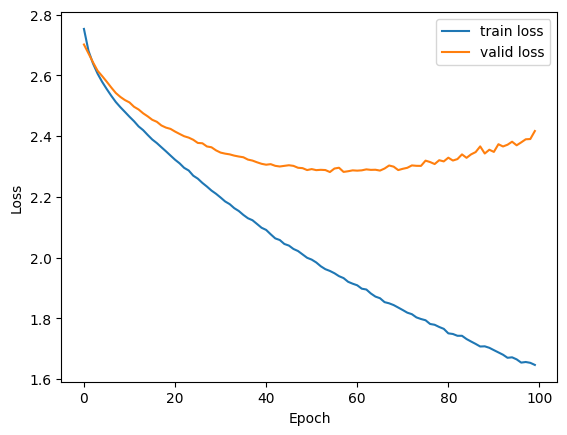

In [26]:
plt.plot(range(N), loss_train_hist, label = 'train loss')
plt.plot(range(N), loss_valid_hist, label = 'valid loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

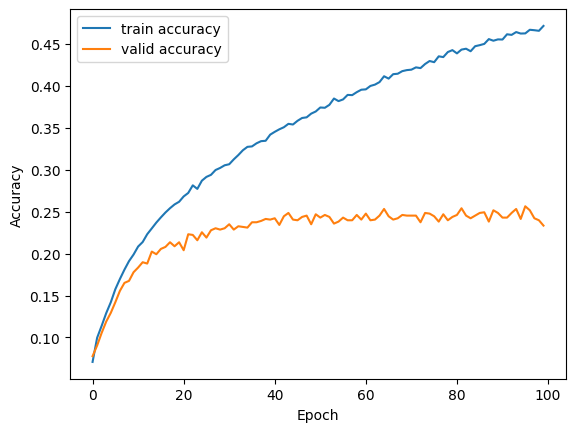

In [27]:
plt.plot(range(N), acc_train_hist, label = 'train accuracy')
plt.plot(range(N), acc_valid_hist, label = 'valid accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()